# Creating own DAN 

In [1]:
import os
import tensorflow as tf
# from keras.layers import Layer
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from typing import *
import pickle
import random
from nltk.tokenize import sent_tokenize
import seaborn as sns

## Reading Data

In [2]:
data_dir = "../datasets/cleaned_datasets/filtered_dataset"

In [3]:
def read_data(_dir:str) -> pd.DataFrame:
    data = {}
    #data["url"] = []
    data["text"] = []
    data["class"] = []
    for root, dirs, files in os.walk(_dir):
        for _dir in dirs: 
            for txt_file in [x for x in os.listdir(os.path.join(root, _dir)) if x.endswith((".txt", ".TXT"))]:
                # Class name = dir name
                class_name = _dir
                #Read File
                file_name = os.path.abspath(os.path.join(root, _dir, txt_file))
                file = open(file_name, "r")
                txt = file.read()
                file.close()
                #data["url"].append(file_name)
                data["text"].append(txt)
                data["class"].append(class_name)
    df = pd.DataFrame.from_dict(data)
    del data
    return df

In [4]:
df = read_data(data_dir).sample(frac = 1)

In [5]:
df.head()

,text,class
1307,however if discharge from hospital is treated ...,prediction
283,results and discussion in the present study co...,prediction
2128,multilabel classification is a challenging res...,prediction
3310,introduction combining multiple clusterings fo...,clustering
6721,in this paper we propose a novel method based ...,pattern_mining


## Creating One-Hot-Encodings

In [6]:
from sklearn import preprocessing

# Transform classes into dummies
le = preprocessing.LabelEncoder()

classes = df.drop(["text"], axis = 1)
classes.apply(le.fit_transform)

# Create One Hot Encodings
enc = preprocessing.OneHotEncoder()
enc.fit(classes)


one_hot_encodings = enc.transform(classes)

In [7]:
one_hot_encodings = one_hot_encodings.toarray()

In [8]:
df.shape

(11874, 2)

## Embeddings

In [9]:
class FastText():
    """
    Loads the FastText model and get the Vectors.
    """

    def __init__(self, **kwargs):
        # super().__init__(**kwargs)
        self.path = "/Users/Daniel/PycharmProjects/Recommender-System/notebooks/FastText/ft_model_15000.pkl"
        self.__initialize_model()

    def __initialize_model(self, **kwargs):
        try:
            tf.logging.info("FastText Model is loading")
            self.model = pickle.load(open(self.path, "rb"))
            tf.logging.info("FastText Model loaded!")
        except Exception as e:
            tf.logging.warning("Something went wrong while loading the FastText Model..")
            tf.logging.warning(e)

    def inference(self, words: List[str]) -> np.ndarray:
        embeddings = []
        for word in words:
            if self.model.wv.__contains__(word):
                embeddings.append(self.model.wv.__getitem__(word))
        return np.array(embeddings)


In [10]:
ft_path = "/Users/Daniel/PycharmProjects/Recommender-System/notebooks/FastText/ft_model_15000.pkl"
fast_text_model = FastText()

INFO:tensorflow:FastText Model is loading
INFO:tensorflow:FastText Model loaded!


## Creating Layer
We need: 
    1. Input Layer with Dropout
    2. Average Layer
    3. Dense Layer
    4. Dense Layer (Classifier)
    5. Output Softmax Layer

In [11]:
paragraphs = [["this", "sucks"], ["hello", "my", "name", "is", "daniel"],["clustering", "is", "amazing"]]
paragraphs_y = np.asarray([[0,1,0], [0,0,1], [1,0,0]])

In [12]:
input_layer = fast_text_model.inference(paragraphs[1])

In [13]:
input_layer.shape

(5, 100)

In [14]:
paragraphs_y.shape

(3, 3)

### Placeholder

In [15]:
x_input = tf.placeholder(dtype = tf.float64, shape = (None, 100), name = "placeholder_input")

In [16]:
y_true = tf.placeholder(dtype = tf.float64, shape = (None, 3), name = "placeholder_y_true")

### Costumized Layers

In [17]:
def dropout_layer(input_layer:np.ndarray ,dropout_prob:float = 0.2):
    #dist = tf.contrib.distributions.Binomial(1, self.drop)
    dist = 1 - np.random.binomial(1, dropout_prob, input_layer.shape[0])
    return input_layer[dist.astype(bool)]

In [18]:
dl = dropout_layer(input_layer)

In [19]:
def average_layer(dropout_layer:np.ndarray, placeholder: tf.placeholder,name= "average_layer"):
    with tf.name_scope(name):
        average = tf.reduce_mean(input_tensor=placeholder, axis=0)
        return tf.reshape(average, (1,-1), name = "average_layer")

In [20]:
average = average_layer(dl, x_input)

### Creating the Dense Layers for DAN

In [21]:
dense_layer_1 = tf.layers.dense(inputs=average,
                                      units=100,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="dense_layer_1")

In [22]:
dense_layer_2 = tf.layers.dense(inputs=dense_layer_1,
                                      units=100,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="dense_layer_2")

In [23]:
dense_layer_3 = tf.layers.dense(inputs=dense_layer_2,
                                      units=100,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="dense_layer_3")

In [24]:
dense_layer_4 = tf.layers.dense(inputs=dense_layer_3,
                                      units=100,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="dense_layer_4")

### Creating the Dense Layers for Clasification

In [25]:
dense_layer_5 = tf.layers.dense(inputs=dense_layer_4,
                                      units=200,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="dense_layer_5")

In [26]:
logits = tf.layers.dense(inputs=dense_layer_5,
                                      units=3,
                                      activation=tf.nn.tanh,
                                      use_bias=True,
                                      trainable=True,
                                      name="logits")

### Softmax Layer & Loss Function
https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2

In [27]:
with tf.name_scope("loss"):
    softmax_layer = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_true, logits=logits) # WTF Is this function actually? 
    cross_entropy = tf.reduce_mean(softmax_layer)
    tf.summary.scalar("cross_entropy", cross_entropy)

### Optimizer

In [28]:
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    train = optimizer.minimize(cross_entropy)
    

### Metrics - Accuracy

In [29]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_true))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

## Saver

In [30]:
saver = tf.train.Saver()

In [31]:
save_path = "dan_checkpoints/" # Need to exist 

In [32]:
model_name = "first_dan.ckpt"

In [33]:
# Check the Graph
if not os.path.isdir(save_path):
    os.makedirs(save_path)

## Training

In [34]:
init = tf.global_variables_initializer()

10 Epoches rund 6 Minuten

In [35]:
%%time
with tf.Session() as sess: 
    sess.run(init)
    
    ### Tensorboard Stuff
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(save_path)
    writer.add_graph(sess.graph)

    epoches = 10
    for i in range(epoches):
        for j,p in enumerate([word_tokenize(x) for x in df["text"].tolist()]): 
            # Converting paragraphs to Embeddings
            embeddings = dropout_layer(fast_text_model.inference(p))
            label = np.array(one_hot_encodings[j]).reshape(1,-1)
            [_, train_accuracy, summary] = sess.run([train, accuracy, merged_summary], feed_dict={x_input:embeddings, y_true:label})
            writer.add_summary(summary = summary, global_step = i)
            writer.flush()
            #[train_accurcy, summary] = sess.run([accuracy, merged_summary], feed_dict={x_input:embeddings, y_true:label})
        print("Accuracy after Epoch: {}".format(train_accuracy))
    
    saver.save(sess, os.path.join(save_path, model_name))
    print("model_saved!")
    sess.close()

Accuracy after Epoch: 0.0
Accuracy after Epoch: 0.0
Accuracy after Epoch: 0.0
Accuracy after Epoch: 0.0
Accuracy after Epoch: 0.0
Accuracy after Epoch: 0.0
Accuracy after Epoch: 0.0
Accuracy after Epoch: 0.0
Accuracy after Epoch: 0.0
Accuracy after Epoch: 0.0
model_saved!
CPU times: user 5min 56s, sys: 49.5 s, total: 6min 46s
Wall time: 4min 9s


## Loading the Model

In [36]:
with tf.Session() as sess: 
    saver.restore(sess,os.path.join(save_path, model_name))
    
    # Is it predicting right? 
    embeddings = fast_text_model.inference(["this", "sucks"])
    #print(sess.run(logits, feed_dict={x_input:embeddings}))
    
    #Getting new Embeddings
    #print(sess.run(dense_layer_2, feed_dict={x_input:embeddings}))
    sess.close()

INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt


In [66]:
def get_dan_embedding(text: List[str], layer):
    with tf.Session() as sess: 
        saver.restore(sess,os.path.join(save_path, model_name))

        # Is it predicting right? 
        embeddings = fast_text_model.inference(text)
        dan_emb = sess.run(layer, feed_dict={x_input:embeddings})
        
        sess.close()
        return dan_emb

## Retrieving Embeddings for Examples

In [329]:
example_1 = "i want predict cost"
example_2 = "i want predict stock prize"
example_3 = "i want similar cost"
example_4 = "i want pattern in my costs"

examples = [example_1, example_2, example_3, example_4]

In [330]:
fastText_embeddings = [np.mean(fast_text_model.inference(word_tokenize(x)), axis = 0) for x in examples]

In [331]:
dan_embeddings = np.squeeze([get_dan_embedding(word_tokenize(x), layer = dense_layer_4) for x in examples])

INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt


In [332]:
dan_embeddings = dan_embeddings.tolist()

In [333]:
_df = pd.DataFrame.from_dict({"text": examples, "ft_embedding": fastText_embeddings, "dan_embedding": dan_embeddings})

In [334]:
_df

,text,ft_embedding,dan_embedding
0,i want predict cost,"[0.13824575, 0.4492068, 0.35157588, -0.0956589...","[0.7342431235739231, 0.9351681055695422, -0.58..."
1,i want predict stock prize,"[0.1945199, 0.3696619, 0.16522367, -0.21709582...","[0.7192703987202866, 0.9583220865482183, 0.482..."
2,i want similar cost,"[0.10927786, 0.3648242, 0.23734617, 0.00141632...","[0.7359610178579562, 0.5982608841921955, 0.773..."
3,i want pattern in my costs,"[0.15498453, 0.25325826, 0.14314944, -0.143352...","[0.7789896061993133, 0.9614800042558498, 0.978..."


## PCA

In [335]:
from sklearn.decomposition import PCA

In [336]:
pca_FT = PCA(n_components=2)
pca_DAN = PCA(n_components=2)

In [337]:
matrix_DAN = pca_FT.fit_transform(_df["dan_embedding"].tolist())

In [338]:
matrix_DAN

array([[ 5.23798824,  1.24220604],
       [ 2.30941569, -1.33996041],
       [-4.56657439,  1.96800005],
       [-2.98082954, -1.87024569]])

In [339]:
matrix_FT = pca_FT.fit_transform(_df["ft_embedding"].tolist())

In [340]:
matrix_FT

array([[-0.01255384, -0.51668778],
       [ 1.03186932,  0.12791036],
       [-0.57804832, -0.24185723],
       [-0.44126716,  0.63063465]])

In [341]:
_df["ft_x"] = matrix_FT[:,0]
_df["ft_y"] = matrix_FT[:,1]

In [342]:
_df["dan_x"] = matrix_DAN[:,0]
_df["dan_y"] = matrix_DAN[:,1]

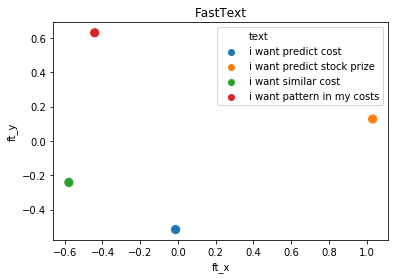

In [343]:
ax = sns.scatterplot(x = "ft_x", y="ft_y", data = _df, s = 100,  hue = "text")
title = ax.set_title("FastText")

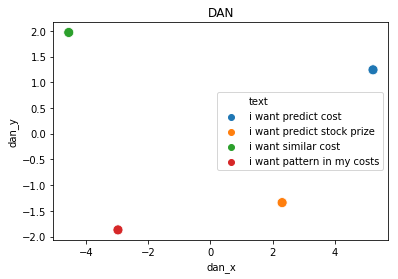

In [344]:
ax = sns.scatterplot(x = "dan_x", y="dan_y", data = _df, s=100, hue = "text")
title = ax.set_title("DAN")

## Pertubation
As used in:  http://cs.umd.edu/~miyyer/pubs/2015_acl_dan.pdf 

In [345]:
# We just append the values to the df
average_layer = []
for embedding in _df["ft_embedding"]:
    average_layer.append(np.linalg.norm(embedding))

In [346]:
layers = []
layers.append(average_layer)

In [347]:
#layers.append(np.array(_norm_layer_1))
for x in [dense_layer_1, dense_layer_2, dense_layer_3, dense_layer_4]:
    lst = []
    for text in _df["text"]:
        lst.append(np.linalg.norm(get_dan_embedding(text, x)))
    layers.append(lst)

INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_checkpoints/first_dan.ckpt
INFO:tensorflow:Restoring parameters from dan_check

In [348]:
layers

[[2.395768, 2.5447118, 2.320776, 2.0617003],
 [1.0120313028403851,
  1.0417034885010217,
  0.9483682212427283,
  0.9860510108590991],
 [1.1714013166642185,
  1.1931081713366054,
  1.147874805275536,
  1.2192174282906245],
 [1.9071569940058046,
  1.9186458110425386,
  2.0197126528032285,
  2.2164840092673495],
 [4.147715752396286, 4.119007438032194, 4.431750982754251, 4.743712810945867]]

In [349]:
np.transpose(layers)

array([[2.39576793, 1.0120313 , 1.17140132, 1.90715699, 4.14771575],
       [2.54471183, 1.04170349, 1.19310817, 1.91864581, 4.11900744],
       [2.32077599, 0.94836822, 1.14787481, 2.01971265, 4.43175098],
       [2.06170034, 0.98605101, 1.21921743, 2.21648401, 4.74371281]])

In [350]:
np.transpose(np.array(layers))[:,0]

array([2.39576793, 2.54471183, 2.32077599, 2.06170034])

In [351]:
for i in range(np.transpose(layers).shape[1]):
    _df["layer_{}".format(i)] = np.transpose(layers)[:,i]

In [352]:
_df.head(1)

,text,ft_embedding,dan_embedding,ft_x,ft_y,dan_x,dan_y,layer_0,layer_1,layer_2,layer_3,layer_4
0,i want predict cost,"[0.13824575, 0.4492068, 0.35157588, -0.0956589...","[0.7342431235739231, 0.9351681055695422, -0.58...",-0.012554,-0.516688,5.237988,1.242206,2.395768,1.012031,1.171401,1.907157,4.147716


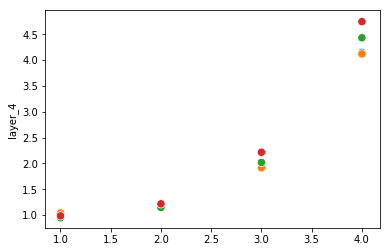

In [353]:
for i,column in enumerate(_df[["layer_1", "layer_2", "layer_3", "layer_4"]]):
    ax = sns.scatterplot(x = [i+1 for x in range(4)], y = column , s = 70, data=_df, hue="text")
    ax.get_legend().remove()
    

In [354]:
_df = _df.drop(columns = ["text","ft_embedding", "dan_embedding", "ft_x", "ft_y", "dan_x", "dan_y"])

In [367]:
_df = _df.drop(columns = ["layer_0"])

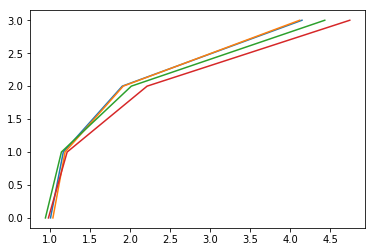

In [368]:
for row in _df.iterrows():
    
    row = sns.lineplot(x = row[1].values, y = range(row[1].values.shape[0]))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(np.ones(shape=(4,1)),_layers[0])
plt.scatter([2 for x in range(4)], _layers[1])
plt.scatter([3 for x in range(4)], _layers[2])
plt.scatter([4 for x in range(4)], _layers[3])